In [1]:
# -*- coding: utf-8 -*-
"""MNIST with Bi-Tempered Loss

Modified to use Bi-Tempered Logistic Loss for robust training with noisy labels
"""

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn import metrics


In [2]:

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [3]:


# ============================================================================
# Bi-Tempered Loss Implementation
# ============================================================================

def log_t(u, t):
    """Compute the tempered logarithm log_t(u)."""
    if t == 1.0:
        return torch.log(u.clamp(min=1e-8))
    else:
        return (torch.pow(u, 1.0 - t) - 1.0) / (1.0 - t)


def exp_t(u, t):
    """Compute the tempered exponential exp_t(u)."""
    if t == 1.0:
        return torch.exp(u.clamp(min=-100.0, max=100.0))
    else:
        return torch.pow(
            torch.clamp(1.0 + (1.0 - t) * u, min=1e-6),
            1.0 / (1.0 - t)
        )


def compute_normalization_fixed_point(activations, t, num_iters=5):
    """Compute normalization value for tempered softmax using fixed-point iteration."""
    mu = activations.max(dim=-1, keepdim=True)[0]
    normalized_activations = activations - mu

    effective_activations = exp_t(normalized_activations, t)
    normalization_constants = effective_activations.sum(dim=-1, keepdim=True)

    for _ in range(num_iters):
        logt_partition = log_t(normalization_constants, t)
        normalized_activations = activations - mu - logt_partition
        effective_activations = exp_t(normalized_activations, t)
        normalization_constants = effective_activations.sum(dim=-1, keepdim=True)

    return normalization_constants


def tempered_softmax(activations, t, num_iters=5):
    """Compute tempered softmax probabilities."""
    if t == 1.0:
        return F.softmax(activations, dim=-1)

    normalization_constants = compute_normalization_fixed_point(
        activations, t, num_iters
    )

    mu = activations.max(dim=-1, keepdim=True)[0]
    logt_partition = log_t(normalization_constants, t)
    normalized_activations = activations - mu - logt_partition

    probabilities = exp_t(normalized_activations, t)

    return probabilities


class BiTemperedLogisticLoss(nn.Module):
    """Bi-Tempered Logistic Loss with custom gradient.

    Args:
        t1: Temperature 1 (< 1.0 for boundedness)
        t2: Temperature 2 (> 1.0 for tail heaviness, < 1.0 for finite support)
        label_smoothing: Label smoothing parameter between [0, 1)
        num_iters: Number of iterations to run the method
        reduction: Specifies the reduction to apply to the output
    """

    def __init__(self, t1=1.0, t2=1.0, label_smoothing=0.0, num_iters=5, reduction='mean'):
        super(BiTemperedLogisticLoss, self).__init__()
        self.t1 = t1
        self.t2 = t2
        self.label_smoothing = label_smoothing
        self.num_iters = num_iters
        self.reduction = reduction

    def forward(self, activations, labels):
        """
        Args:
            activations: A tensor with shape (..., num_classes) - raw logits
            labels: A tensor with integer class labels OR one-hot encoded labels

        Returns:
            A loss tensor
        """
        # Convert integer labels to one-hot if needed
        if labels.dim() == 1 or labels.size(-1) != activations.size(-1):
            num_classes = activations.size(-1)
            labels = F.one_hot(labels.long(), num_classes).float()

        if self.label_smoothing > 0.0:
            num_classes = labels.size(-1)
            labels = (
                1 - num_classes / (num_classes - 1) * self.label_smoothing
            ) * labels + self.label_smoothing / (num_classes - 1)

        # Check if we should use standard cross-entropy
        if self.t1 == 1.0 and self.t2 == 1.0:
            log_probs = F.log_softmax(activations, dim=-1)
            loss_values = -torch.sum(labels * log_probs, dim=-1)
        else:
            # Use custom bi-tempered loss
            loss_values = self._bi_tempered_logistic_loss(activations, labels)

        if self.reduction == 'mean':
            return loss_values.mean()
        elif self.reduction == 'sum':
            return loss_values.sum()
        else:
            return loss_values

    def _bi_tempered_logistic_loss(self, activations, labels):
        """Compute bi-tempered logistic loss."""
        probabilities = tempered_softmax(activations, self.t2, self.num_iters)

        loss_values = torch.sum(
            labels * (
                log_t(labels + 1e-10, self.t1) - log_t(probabilities, self.t1)
            ) - 1.0 / (2.0 - self.t1) * (
                torch.pow(labels, 2.0 - self.t1) -
                torch.pow(probabilities, 2.0 - self.t1)
            ),
            dim=-1
        )

        return loss_values




In [4]:
# ============================================================================
# Model Definition
# ============================================================================

class MNISTModel(nn.Module):
    def __init__(self):
        super(MNISTModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=0)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=0)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(64 * 5 * 5, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = self.flatten(x)
        x = self.dropout(x)
        x = self.fc(x)
        return x


In [5]:


# ============================================================================
# Data Loading and Preparation
# ============================================================================

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load MNIST data
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Extract data and labels
x_train = train_dataset.data.numpy().astype('float32') / 255.0
y_train = train_dataset.targets.numpy()
x_test = test_dataset.data.numpy().astype('float32') / 255.0
y_test = test_dataset.targets.numpy()

# Reshape data
x_train = x_train.reshape(-1, 1, 28, 28)
x_test = x_test.reshape(-1, 1, 28, 28)

# Add noisy labels
NOISE_LEVEL = 0.4
perm = np.array([7, 9, 0, 4, 2, 1, 3, 5, 6, 8])
noise = perm[y_train]

if NOISE_LEVEL > 0:
    _, noise_idx = next(iter(StratifiedShuffleSplit(n_splits=1,
                                                    test_size=NOISE_LEVEL,
                                                    random_state=42).split(x_train, y_train)))
    y_train_noise = y_train.copy()
    y_train_noise[noise_idx] = noise[noise_idx]

    train_idx, val_idx = next(iter(
        StratifiedShuffleSplit(n_splits=1, test_size=0.1,
                              random_state=42).split(x_train, y_train_noise)))

    X_train_train = x_train[train_idx]
    y_train_correct = y_train[train_idx]
    y_train_train = y_train_noise[train_idx]
    X_train_val = x_train[val_idx]
    y_train_val = y_train_noise[val_idx]
    y_train_val_correct = y_train[val_idx]
else:
    train_idx, val_idx = next(iter(
        StratifiedShuffleSplit(n_splits=1, test_size=0.1,
                              random_state=42).split(x_train, y_train)))
    X_train_train = x_train[train_idx]
    y_train_train = y_train[train_idx]
    y_train_correct = y_train[train_idx]
    X_train_val = x_train[val_idx]
    y_train_val = y_train[val_idx]
    y_train_val_correct = y_train[val_idx]

# Convert to PyTorch tensors
X_train_train = torch.FloatTensor(X_train_train)
y_train_train = torch.LongTensor(y_train_train)
X_train_val = torch.FloatTensor(X_train_val)
y_train_val_correct = torch.LongTensor(y_train_val_correct)
x_test = torch.FloatTensor(x_test)
y_test = torch.LongTensor(y_test)

# Create DataLoaders
train_dataset = TensorDataset(X_train_train, y_train_train)
val_dataset = TensorDataset(X_train_val, y_train_val_correct)
test_dataset = TensorDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)


Using device: cuda


100%|██████████| 9.91M/9.91M [00:00<00:00, 20.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 499kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.51MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.96MB/s]


In [6]:

# Training function
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

    return running_loss / len(loader), correct / total


# Validation function
def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    return running_loss / len(loader), correct / total



In [7]:


# ============================================================================
# Training Setup with Bi-Tempered Loss
# ============================================================================

# Initialize model
model = MNISTModel().to(device)
optimizer = optim.Adam(model.parameters())

# Use Bi-Tempered Loss with parameters optimized for noisy labels
# t1 < 1.0 for bounded loss (robustness to outliers)
# t2 > 1.0 for heavy-tailed probabilities (robustness to mislabeled examples)
criterion = BiTemperedLogisticLoss(
    t1=0.8,              # Bounded loss
    t2=1.2,              # Heavy-tailed probabilities
    label_smoothing=0.1, # Optional: helps with noisy labels
    num_iters=5
)

print(f"Using Bi-Tempered Loss with t1={criterion.t1}, t2={criterion.t2}")


# ============================================================================
# Training Loop
# ============================================================================

epochs = 10
patience = 4
best_val_loss = float('inf')
patience_counter = 0

history = {
    'loss': [],
    'accuracy': [],
    'val_loss': [],
    'val_accuracy': []
}

print(f"\nStarting training with noise level: {NOISE_LEVEL}")
print("=" * 60)

for epoch in range(epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)

    history['loss'].append(train_loss)
    history['accuracy'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_acc)

    print(f"Epoch {epoch+1}/{epochs}")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save best model
        torch.save(model.state_dict(), 'best_model_bitempered.pth')
        print(f"  → Best model saved!")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"\nEarly stopping triggered after epoch {epoch+1}")
            break

print("=" * 60)






Using Bi-Tempered Loss with t1=0.8, t2=1.2

Starting training with noise level: 0.4
Epoch 1/10
  Train Loss: 1.2644, Train Acc: 0.2593
  Val Loss: 0.5796, Val Acc: 0.7207
  → Best model saved!
Epoch 2/10
  Train Loss: 0.7885, Train Acc: 0.4980
  Val Loss: 0.4652, Val Acc: 0.8083
  → Best model saved!
Epoch 3/10
  Train Loss: 0.7124, Train Acc: 0.5230
  Val Loss: 0.4044, Val Acc: 0.8517
  → Best model saved!
Epoch 4/10
  Train Loss: 0.6800, Train Acc: 0.5358
  Val Loss: 0.4112, Val Acc: 0.8517
Epoch 5/10
  Train Loss: 0.6617, Train Acc: 0.5441
  Val Loss: 0.3864, Val Acc: 0.8640
  → Best model saved!
Epoch 6/10
  Train Loss: 0.6476, Train Acc: 0.5480
  Val Loss: 0.3892, Val Acc: 0.8708
Epoch 7/10
  Train Loss: 0.6390, Train Acc: 0.5507
  Val Loss: 0.3903, Val Acc: 0.8637
Epoch 8/10
  Train Loss: 0.6327, Train Acc: 0.5521
  Val Loss: 0.3882, Val Acc: 0.8622
Epoch 9/10
  Train Loss: 0.6261, Train Acc: 0.5565
  Val Loss: 0.3423, Val Acc: 0.9098
  → Best model saved!
Epoch 10/10
  Train Los

In [8]:
# ============================================================================
# Evaluation
# ============================================================================

# Load best model
model.load_state_dict(torch.load('best_model_bitempered.pth'))

# Evaluate on test set
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(targets.numpy())

y_pred = np.array(y_pred)
y_true = np.array(y_true)

acc = metrics.accuracy_score(y_true, y_pred)
macro_averaged_f1 = metrics.f1_score(y_true, y_pred, average='macro')

print("\nTest Set Results:")
print(f"  Accuracy: {acc:.4f}")
print(f"  Macro F1: {macro_averaged_f1:.4f}")
print(f"  Noise Level: {NOISE_LEVEL}")


Test Set Results:
  Accuracy: 0.9090
  Macro F1: 0.9081
  Noise Level: 0.4


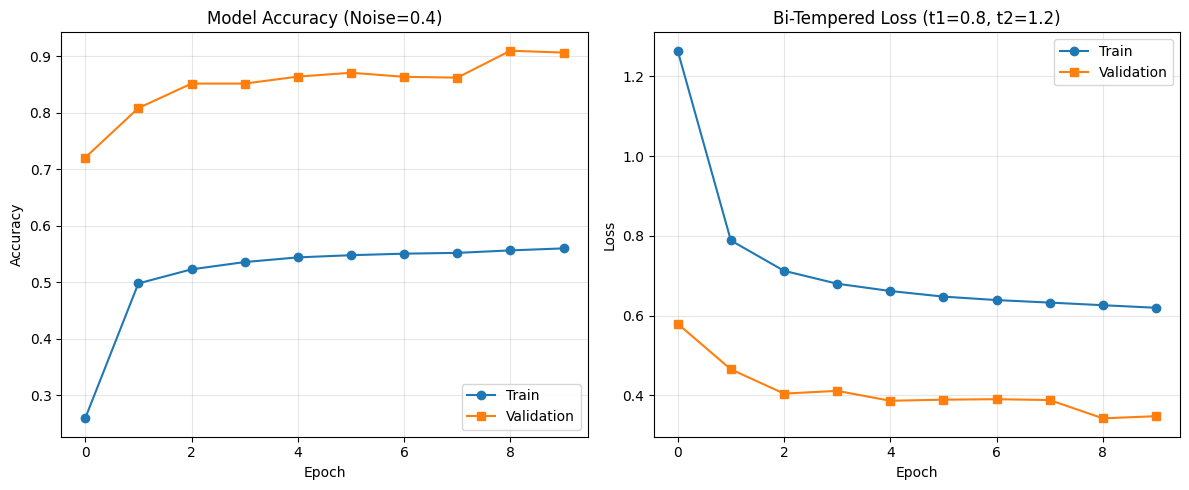


Training completed! Model trained with Bi-Tempered Loss (t1=0.8, t2=1.2)


In [9]:

# ============================================================================
# Visualization
# ============================================================================

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], marker='o', label='Train')
plt.plot(history['val_accuracy'], marker='s', label='Validation')
plt.title(f'Model Accuracy (Noise={NOISE_LEVEL})')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history['loss'], marker='o', label='Train')
plt.plot(history['val_loss'], marker='s', label='Validation')
plt.title(f'Bi-Tempered Loss (t1={criterion.t1}, t2={criterion.t2})')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history_bitempered.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nTraining completed! Model trained with Bi-Tempered Loss (t1={criterion.t1}, t2={criterion.t2})")